In [1]:
import cv2
import sys, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
import Image
import cPickle as pickle

### Load & Test

In [3]:
imageFile = '/Users/markus/Work/data/imdb_crop/00/nm0000100_rm1001569280_1955-1-6_2011.jpg'
cascFile ="/Users/markus/Work/Insight-AI-Project/preprocess/FaceDetect/haarcascade_frontalface_default.xml"
#cascFile ="/Users/markus/Work/Insight-AI-Project/preprocess/haarcascade_frontalface_default.xml"
#cascFile ="/Users/markus/Work/Insight-AI-Project/preprocess/haarcascade_frontalface_eye.xml"

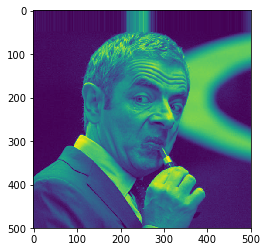

In [4]:
# test
faceCascade = cv2.CascadeClassifier(cascFile)
image = cv2.imread(imageFile)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

### Functions

In [5]:
# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascFile)


def detectFaces(image,faceCascade):
    # Read the image
    #image = cv2.imread(imageFile)   
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
        # flags = cv2.cv.CV_HAAR_SCALE_IMAGE
        
    )
    #faces = faceCascade.detectMultiScale(gray, 1.3, 5)
    return faces

def crop_resize(image,cropRect,imaSize=64):
    x,y,w,h = cropRect
    cropped = image[y:y+h,x:x+w]
    return cv2.resize(cropped,(imaSize,imaSize), interpolation = cv2.INTER_CUBIC)

In [6]:
image = cv2.imread(imageFile)
faces = detectFaces(image,faceCascade)
print("Found {0} faces!".format(len(faces)))

Found 0 faces!


### Check list of images for IMDB

In [7]:
imagePath = "/Users/markus/Work/data/imdb_crop/00/"
imageList=sorted(os.listdir(imagePath))
nima = len(imageList)
print("Found {} images".format(nima))

ct = time.time()
numFaces=np.zeros(nima)

for k in xrange(10):#nima):
    image = cv2.imread(imagePath+imageList[k])
    faces = detectFaces(image,faceCascade)
    numFaces[k] = len(faces)

print("Time = {}".format(time.time()-ct))
print(sum(numFaces==1))

Found 3862 images
Time = 0.225005865097
3


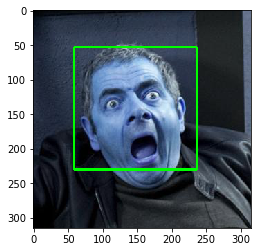

In [8]:
k=2
image = cv2.imread(imagePath+imageList[k])
faces = detectFaces(image,faceCascade)

for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

_=plt.imshow(image)    

(32, 32, 3)


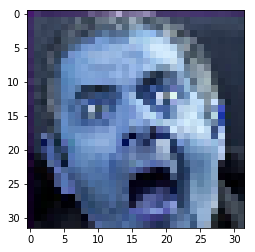

In [9]:
cropped = crop_resize(image,faces[0],32)
print(cropped.shape)
plt.imshow(cropped)
#plt.imshow(image)

### Load Meta table

In [10]:
meta = pd.read_pickle("wiki_meta_clean.pkl")
print(meta.shape)
meta.head(2)

(40190, 9)


,full_path,dob,face_location,face_score,gender,photo_taken,second_face_score,age,ageLabel
0,00/10049200_1891-09-16_1958.jpg,690933,126.869 111.111 267.897 252.138,5.2548,0.0,1958,NaN,66,5
1,00/10110600_1985-09-17_2012.jpg,725267,217.681 129.039 305.324 216.681,3.6931,1.0,2012,NaN,26,1


In [12]:
!ls ../../data

aligned
aligned.tar.gz
db
frontalFace10
frontalimages_manuallyaligned_part1.zip
frontalimages_spatiallynormalized_part1.zip
imdb_crop
imdb_crop.tar
wiki
wiki.tar
wiki_crop
wiki_crop.tar
wiki_crop_aligned_wOpenFace
wiki_crop_clean_128
wiki_crop_clean_64


In [30]:
sourcePath='../../data/wiki_crop/'
destPath  ='../../data/wiki_crop_clean_128/'

In [31]:
imaSize = 128

ct = time.time()

ageLabel={}

if not os.path.exists(destPath):
    print("create "+destPath)
    os.makedirs(destPath)

for k in meta.index:#xrange(1000):
    imaFile = meta.full_path[k]
    sourceFile = sourcePath+imaFile
    if not os.path.isfile(sourceFile):
        print "Does not exit: " + imaFile
    else:
        image = cv2.imread(sourceFile)
        faces = detectFaces(image,faceCascade)
        if len(faces)==1:
            cropped = crop_resize(image,faces[0],imaSize)
            
            if ageLabel.has_key(imaFile[3:]):
                print "Files not unique!"
            else:
                ageClass = int(meta.ageLabel[k])
                destFile = imaFile[3:].replace('.jpg','_age{}.jpg'.format(ageClass))
                ageLabel[destFile]= ageClass
                cv2.imwrite(destPath+destFile,cropped)
        else:
            pass
            #print(imaFile+": Found {} faces".format(len(faces)))
        
print("time: {} sec".format((time.time()-ct))) 

create ../../data/wiki_crop_clean_128/
time: 795.773707867 sec


In [28]:
df=pd.DataFrame(ageLabel.items(), columns=['File', 'AgeLabel'])
print df.shape
df.head()

(25815, 2)


,File,AgeLabel
0,23655297_1990-07-01_2010_age1.jpg,1
1,4324332_1943-02-09_1962_age1.jpg,1
2,31661086_1993-06-28_2013_age1.jpg,1
3,10705806_1982-05-13_2009_age1.jpg,1
4,2726391_1964-08-21_2012_age3.jpg,3


In [29]:
# save to file
df.to_pickle('wiki_clean_crop_File-Age-DF2.pkl')

In [22]:
# create dictionary file -> ageLabel
imageLabels = df.set_index('File').T.to_dict('list')
imageLabels["15132889_1986-10-23_2008.jpg"][0] # test

1

### Save Files in numpy array

In [23]:
imagePath = '../../data/wiki_crop_clean_64/'

In [31]:
imageList=sorted(os.listdir(imagePath))
imaArr    = np.array([np.array(Image.open(imagePath+imaFile)) for imaFile in imageList])
imaLabels = np.array([imageLabels[imaFile][0] for imaFile in imageList])
print(imaArr.shape, imaLabels.shape)

((25815, 64, 64, 3), (25815,))


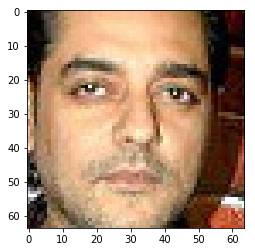

In [25]:
plt.imshow(imaArr[15])

In [28]:
with open('../data/faces_wiki_crop_clean_64_images.pkl', 'wb') as handle:
    pickle.dump(imaArr, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/faces_wiki_crop_clean_64_labels.pkl', 'wb') as handle:
    pickle.dump(imaLabels, handle, protocol=pickle.HIGHEST_PROTOCOL)



### Convert image folder to pkl

((23373, 64, 64, 3), (23373,))


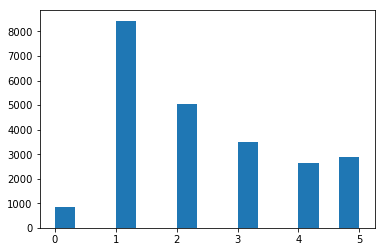

In [43]:
imagePath     = '../../data/wiki_crop_clean_64_aligned/'
outFileImages = '../data/faces_wiki_crop_clean_64_aligned_images.pkl'
outFileLabels = '../data/faces_wiki_crop_clean_64_aligned_labels.pkl'

imageList=sorted(os.listdir(imagePath))
imaArr  =np.array([np.array(Image.open(imagePath+imaFile)) for imaFile in imageList])
imaLabels = np.array([int(imaFile[-5]) for imaFile in imageList])

print(imaArr.shape,imaLabels.shape)

with open(outFileImages, 'wb') as handle:
    pickle.dump(imaArr, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(outFileLabels, 'wb') as handle:
    pickle.dump(imaLabels, handle, protocol=pickle.HIGHEST_PROTOCOL)

_=plt.hist(imaLabels,bins=15)

### Check and remove gray-level images

In [51]:
imagePath     = '../../data/imdb-wiki_crop_clean_align128/'
imageList=sorted(os.listdir(imagePath))

imaArr = []
imaLabel = []
imaLabelAll = []

colorThresh = 31

ct = time.time()
for imaFile in imageList:
    if not imaFile.endswith(".png"):#imaFile.endswith(".jpg"):
        continue
    ima = np.array(Image.open(imagePath+imaFile))
    imaLabelAll.append(int(imaFile[-5]))
    
    if len(ima.shape)<3 or np.max(np.abs(ima[:,:,0]-ima[:,:,1]))<colorThresh \
        or np.max(np.abs(ima[:,:,0]-ima[:,:,2]))<colorThresh \
        or np.max(np.abs(ima[:,:,1]-ima[:,:,2]))<colorThresh:
        #imaArr.append(ima)
        imaLabel.append(int(imaFile[-5]))
        # remove file
        os.remove(imagePath+imaFile)

print([len(imageList),len(imaLabel)])
print('time {} min'.format((time.time()-ct)/60.))

[139383, 601]
time 5.21444125175 min


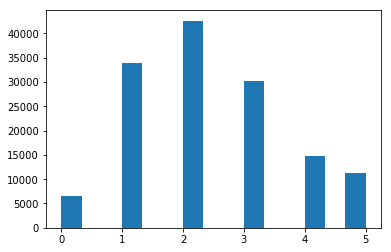

In [47]:
_=plt.hist(imaLabelAll,bins=15)

In [44]:
24*28

672

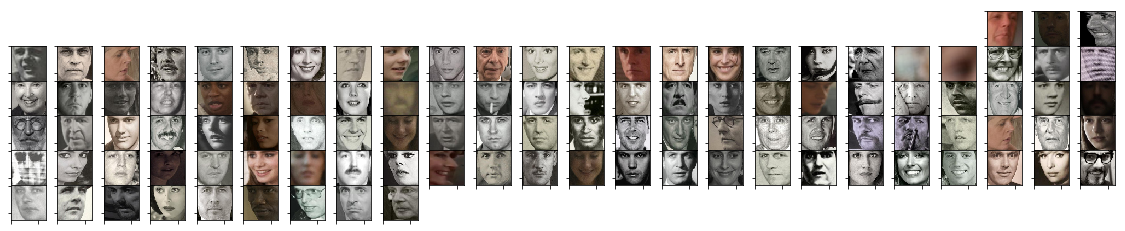

In [46]:
plt.figure(figsize=(20,18))
for k in range(501,len(imaArr)):
    ima = imaArr[k]
    ax = plt.subplot(28,24,k+1)
    plt.imshow(ima/255.)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.subplots_adjust(wspace=0,hspace=0)

### Create a balanced subsample

In [ ]:
imagePath     = '../../data/imdb-wiki_crop_clean_align64/'
imageList=sorted(os.listdir(imagePath))

In [62]:
numPerClass = 10000
nima = len(imageList)
imaIdx = range(nima)

# randomize/shuffle idx
np.random.seed(123)
np.random.shuffle(imaIdx)

classDict = dict([(k,0) for k in range(6)])
subSetIdx =[]

for idx in imaIdx:
    cl = int(imageList[idx][-5])
    if classDict[cl]<numPerClass:
        classDict[cl]+=1
        subSetIdx.append(idx)
    
classDict

{0: 6490, 1: 10000, 2: 10000, 3: 10000, 4: 10000, 5: 10000}

##### Save SubSet

((56490, 64, 64, 3), (56490,))


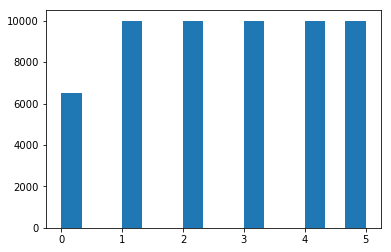

In [67]:
outFileImages = '../data/faces_imdb-wiki_cc_align64_images.pkl'
outFileLabels = '../data/faces_imdb-wiki_cc_align64_labels.pkl'

imaArr  =np.array([np.array(Image.open(imagePath+imageList[idx])) for idx in subSetIdx])
imaLabels = np.array([int(imageList[idx][-5]) for idx in subSetIdx])

print(imaArr.shape,imaLabels.shape)

with open(outFileImages, 'wb') as handle:
    pickle.dump(imaArr, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(outFileLabels, 'wb') as handle:
    pickle.dump(imaLabels, handle, protocol=pickle.HIGHEST_PROTOCOL)

_=plt.hist(imaLabels,bins=15)

In [66]:
!ls ../

README.md  data       keras      pipeline   preprocess
